Para esse exercicio eu usei [ESTE](https://www.kaggle.com/code/startupsci/titanic-data-science-solutions) guia.

n consegui fazer uma pipelide usando as mudanças do guia e o resultado tb acabou sendo pior, mas sinte que aprendi bastante com essa experiencia

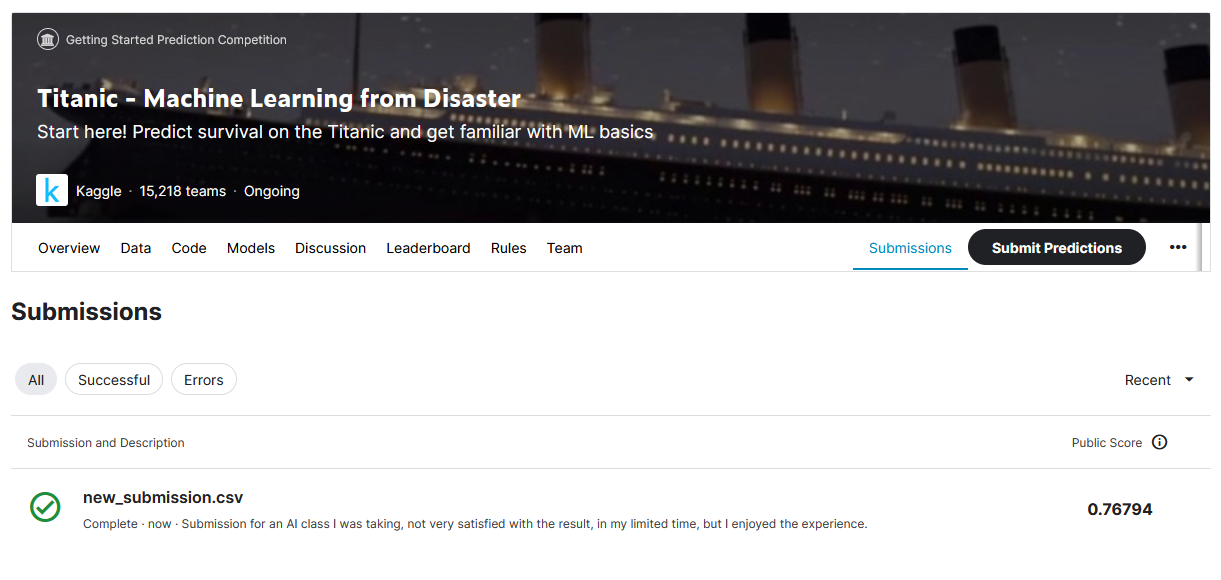

### Imports

In [1]:
import numpy as np
import pandas as pd

# Class
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate

# New solution
import random as rnd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
#from sklearn.tree import DecisionTreeClassifier

### Loading dataset and removing `Y`

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# y = train['Survived']
# X = train.drop('Survived', axis=1)

### Improving data

In [3]:
train_df = train.drop(['Ticket', 'Cabin'], axis=1)
test_df = test.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

"Combine", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape

('Combine', (891, 10), (418, 9), (891, 10), (418, 9))

In [4]:
# deal with name
for dataset in combine:
  dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

for dataset in combine:
  dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

  dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
  dataset['Title'] = dataset['Title'].map(title_mapping)
  dataset['Title'] = dataset['Title'].fillna(0)

train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

In [5]:
# deal with sex
for dataset in combine:
  dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


In [6]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,0,34.5,0,0,7.8292,Q,1
1,893,3,1,47.0,1,0,7.0000,S,3
2,894,2,0,62.0,0,0,9.6875,Q,1
3,895,3,0,27.0,0,0,8.6625,S,1
4,896,3,1,22.0,1,1,12.2875,S,3


In [7]:
# deal with age
guess_ages = np.zeros((2,3))

for dataset in combine:
  for i in range(0, 2):
    for j in range(0, 3):
      guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()

      age_guess = guess_df.median()

      guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

  for i in range(0, 2):
    for j in range(0, 3):
      dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1), 'Age'] = guess_ages[i,j]

  dataset['Age'] = dataset['Age'].astype(int)

train_df['AgeBand'] = pd.cut(train_df['Age'], 5)

for dataset in combine:
  dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
  dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
  dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
  dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
  dataset.loc[ dataset['Age'] > 64, 'Age']

train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


In [8]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,0,2,0,0,7.8292,Q,1
1,893,3,1,2,1,0,7.0000,S,3
2,894,2,0,3,0,0,9.6875,Q,1
3,895,3,0,1,0,0,8.6625,S,1
4,896,3,1,1,1,1,12.2875,S,3


In [9]:
# deal with family
for dataset in combine:
  dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine:
  dataset['IsAlone'] = 0
  dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


In [10]:
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,892,3,0,2,7.8292,Q,1,1
1,893,3,1,2,7.0000,S,3,0
2,894,2,0,3,9.6875,Q,1,1
3,895,3,0,1,8.6625,S,1,1
4,896,3,1,1,12.2875,S,3,0


In [11]:
# virtual feature
for dataset in combine:
  dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,S,1,0,3
1,1,1,1,2,71.2833,C,3,0,2
2,1,3,1,1,7.9250,S,2,1,3
3,1,1,1,2,53.1000,S,3,0,2
4,0,3,0,2,8.0500,S,1,1,6


In [12]:
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,Q,1,1,6
1,893,3,1,2,7.0000,S,3,0,6
2,894,2,0,3,9.6875,Q,1,1,6
3,895,3,0,1,8.6625,S,1,1,3
4,896,3,1,1,12.2875,S,3,0,3


In [13]:
# deal with embark
freq_port = train_df.Embarked.dropna().mode()[0]

for dataset in combine:
  dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

for dataset in combine:
  dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


In [14]:
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


In [15]:
# deal with fare
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)

for dataset in combine:
  dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
  dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
  dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
  dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
  dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6


In [16]:
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3


In [ ]:
y = train_df['Survived']
X = train_df.drop('Survived', axis=1)

test_df_fr = test_df.drop('PassengerId', axis=1)
test_df_fr

## Pipeline and Model

In [19]:
pipeline = Pipeline ([
    ('arvore', DecisionTreeClassifier()),
])

scores = cross_validate(pipeline, X, y)
scores, np.mean(scores['test_score'])

({'fit_time': array([0.00690913, 0.00315785, 0.00328064, 0.002846  , 0.00279045]),
  'score_time': array([0.0031321 , 0.00180459, 0.00185394, 0.00174618, 0.00180316]),
  'test_score': array([0.76536313, 0.7752809 , 0.80337079, 0.81460674, 0.8258427 ])},
 0.7968928504174252)

In [20]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'arvore__max_depth': [None, 1, 3, 5, 7, 9],
}

NewModel = GridSearchCV(pipeline, param_grid=parameters)

scores = cross_validate(NewModel, X, y)
scores, np.mean(scores['test_score'])

({'fit_time': array([0.16152287, 0.15065503, 0.16474724, 0.15107846, 0.15815592]),
  'score_time': array([0.00170302, 0.0032115 , 0.00181103, 0.00175667, 0.00178504]),
  'test_score': array([0.7877095 , 0.76966292, 0.80337079, 0.79775281, 0.83146067])},
 0.797991337643588)

## New Submission

In [22]:
NewModel.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('arvore', DecisionTreeClassifier())]),
             param_grid={'arvore__max_depth': [None, 1, 3, 5, 7, 9]})

In [23]:
ypred = NewModel.predict(test_df_fr)

submission = pd.read_csv('gender_submission.csv')
submission['Survived'] = ypred
submission.to_csv('new_submission.csv', index=False)

# class code

In [14]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

y = train['Survived']
X = train.drop('Survived', axis=1)

### Setup Pipeline Component Classes

In [15]:
class AtributosDesejados(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.colunasIndesejadas_ = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    return self
  def transform(self, X, v=None):
    return X.drop(self.colunasIndesejadas_, axis=1)

atributosDesejados = AtributosDesejados()
Xdrop = atributosDesejados.fit_transform(X)
Xdrop.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [16]:
class AtributosNumericos(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.colunasNumericas = X.select_dtypes(include='number').columns
    return self
  def transform(self, X, y=None):
    return X[self.colunasNumericas]

atributosNumericos = AtributosNumericos()
Xnum = atributosNumericos.fit_transform(Xdrop)
Xnum.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [17]:
class AtributosCategoricos(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.colunasCategoricas = X.select_dtypes(include='object').columns
    return self
  def transform(self, X, y=None):
    return X[self.colunasCategoricas]

atributosCategoricos = AtributosCategoricos()
Xcat = atributosCategoricos.fit_transform(Xdrop)
Xcat.columns

Index(['Sex', 'Embarked'], dtype='object')

### Build Pipeline

In [19]:
#class pipelines
pipenum = Pipeline([
    ('atributos_numericos', AtributosNumericos()),
    ('imputer', SimpleImputer(strategy="mean")),
    ('scaler', StandardScaler()),
])

pipecat = Pipeline([
    ('atributos_categoricos', AtributosCategoricos()),
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder()),
])

unecaracteristicas = FeatureUnion([
    ('pipenum', pipenum),
    ('pipecat', pipecat),
])

preproc = Pipeline ([
    ('atributos_desejados', AtributosDesejados()),
    ('unecaracteristicas', unecaracteristicas),
])

pipetotal = Pipeline ([
    ('preproc', preproc),
    ('arvore', DecisionTreeClassifier()),
])

#Nessesary pipelines
pipetotal = Pipeline ([
    ('preproc', preproc),
    ('arvore', DecisionTreeClassifier()),
])

scores = cross_validate(pipetotal, X, y)
scores, np.mean(scores['test_score'])

({'fit_time': array([0.0671165 , 0.0537858 , 0.05489135, 0.07928252, 0.05979276]),
  'score_time': array([0.03038311, 0.03180265, 0.01922631, 0.02355695, 0.04190254]),
  'test_score': array([0.73743017, 0.76404494, 0.80337079, 0.74719101, 0.81460674])},
 0.7733287301487666)

### Create Model

In [55]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

parameters = {
    'arvore__max_depth': [None, 1, 3, 5, 7, 9],
    'preproc__unecaracteristicas__pipenum__imputer__strategy': ['mean', 'median', 'most_frequent']
}

modelo = GridSearchCV(pipetotal, param_grid=parameters)

scores = cross_validate(modelo, X, y)
scores, np.mean(scores['test_score'])

({'fit_time': array([5.08694887, 5.0707376 , 4.83781505, 5.26334691, 4.76939487]),
  'score_time': array([0.01027966, 0.01108193, 0.00729799, 0.00711656, 0.00752044]),
  'test_score': array([0.81564246, 0.82022472, 0.81460674, 0.78651685, 0.83146067])},
 0.8136902893729208)

### Examinate Results

In [15]:
modelo.fit(X, y)
modelo.best_estimator_

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('atributos_desejados', AtributosDesejados()),
                                 ('unecaracteristicas',
                                  FeatureUnion(transformer_list=[('pipenum',
                                                                  Pipeline(steps=[('atributos_numericos',
                                                                                   AtributosNumericos()),
                                                                                  ('imputer',
                                                                                   SimpleImputer()),
                                                                                  ('scaler',
                                                                                   StandardScaler())])),
                                                                 ('pipecat',
                                                                  Pipeline(steps=[('atributos_categoricos',
                                                                                   AtributosCategoricos()),
                                                                                  ('imputer',
                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                  ('encoder',
                                                                                   OneHotEncoder())]))]))])),
                ('arvore', DecisionTreeClassifier(max_depth=9))])

### Generate Submision

In [16]:
ypred = modelo.predict(test)

submission = pd.read_csv('gender_submission.csv')
submission['Survived'] = ypred
submission.to_csv('tree_gscv_submission.csv', index=False)